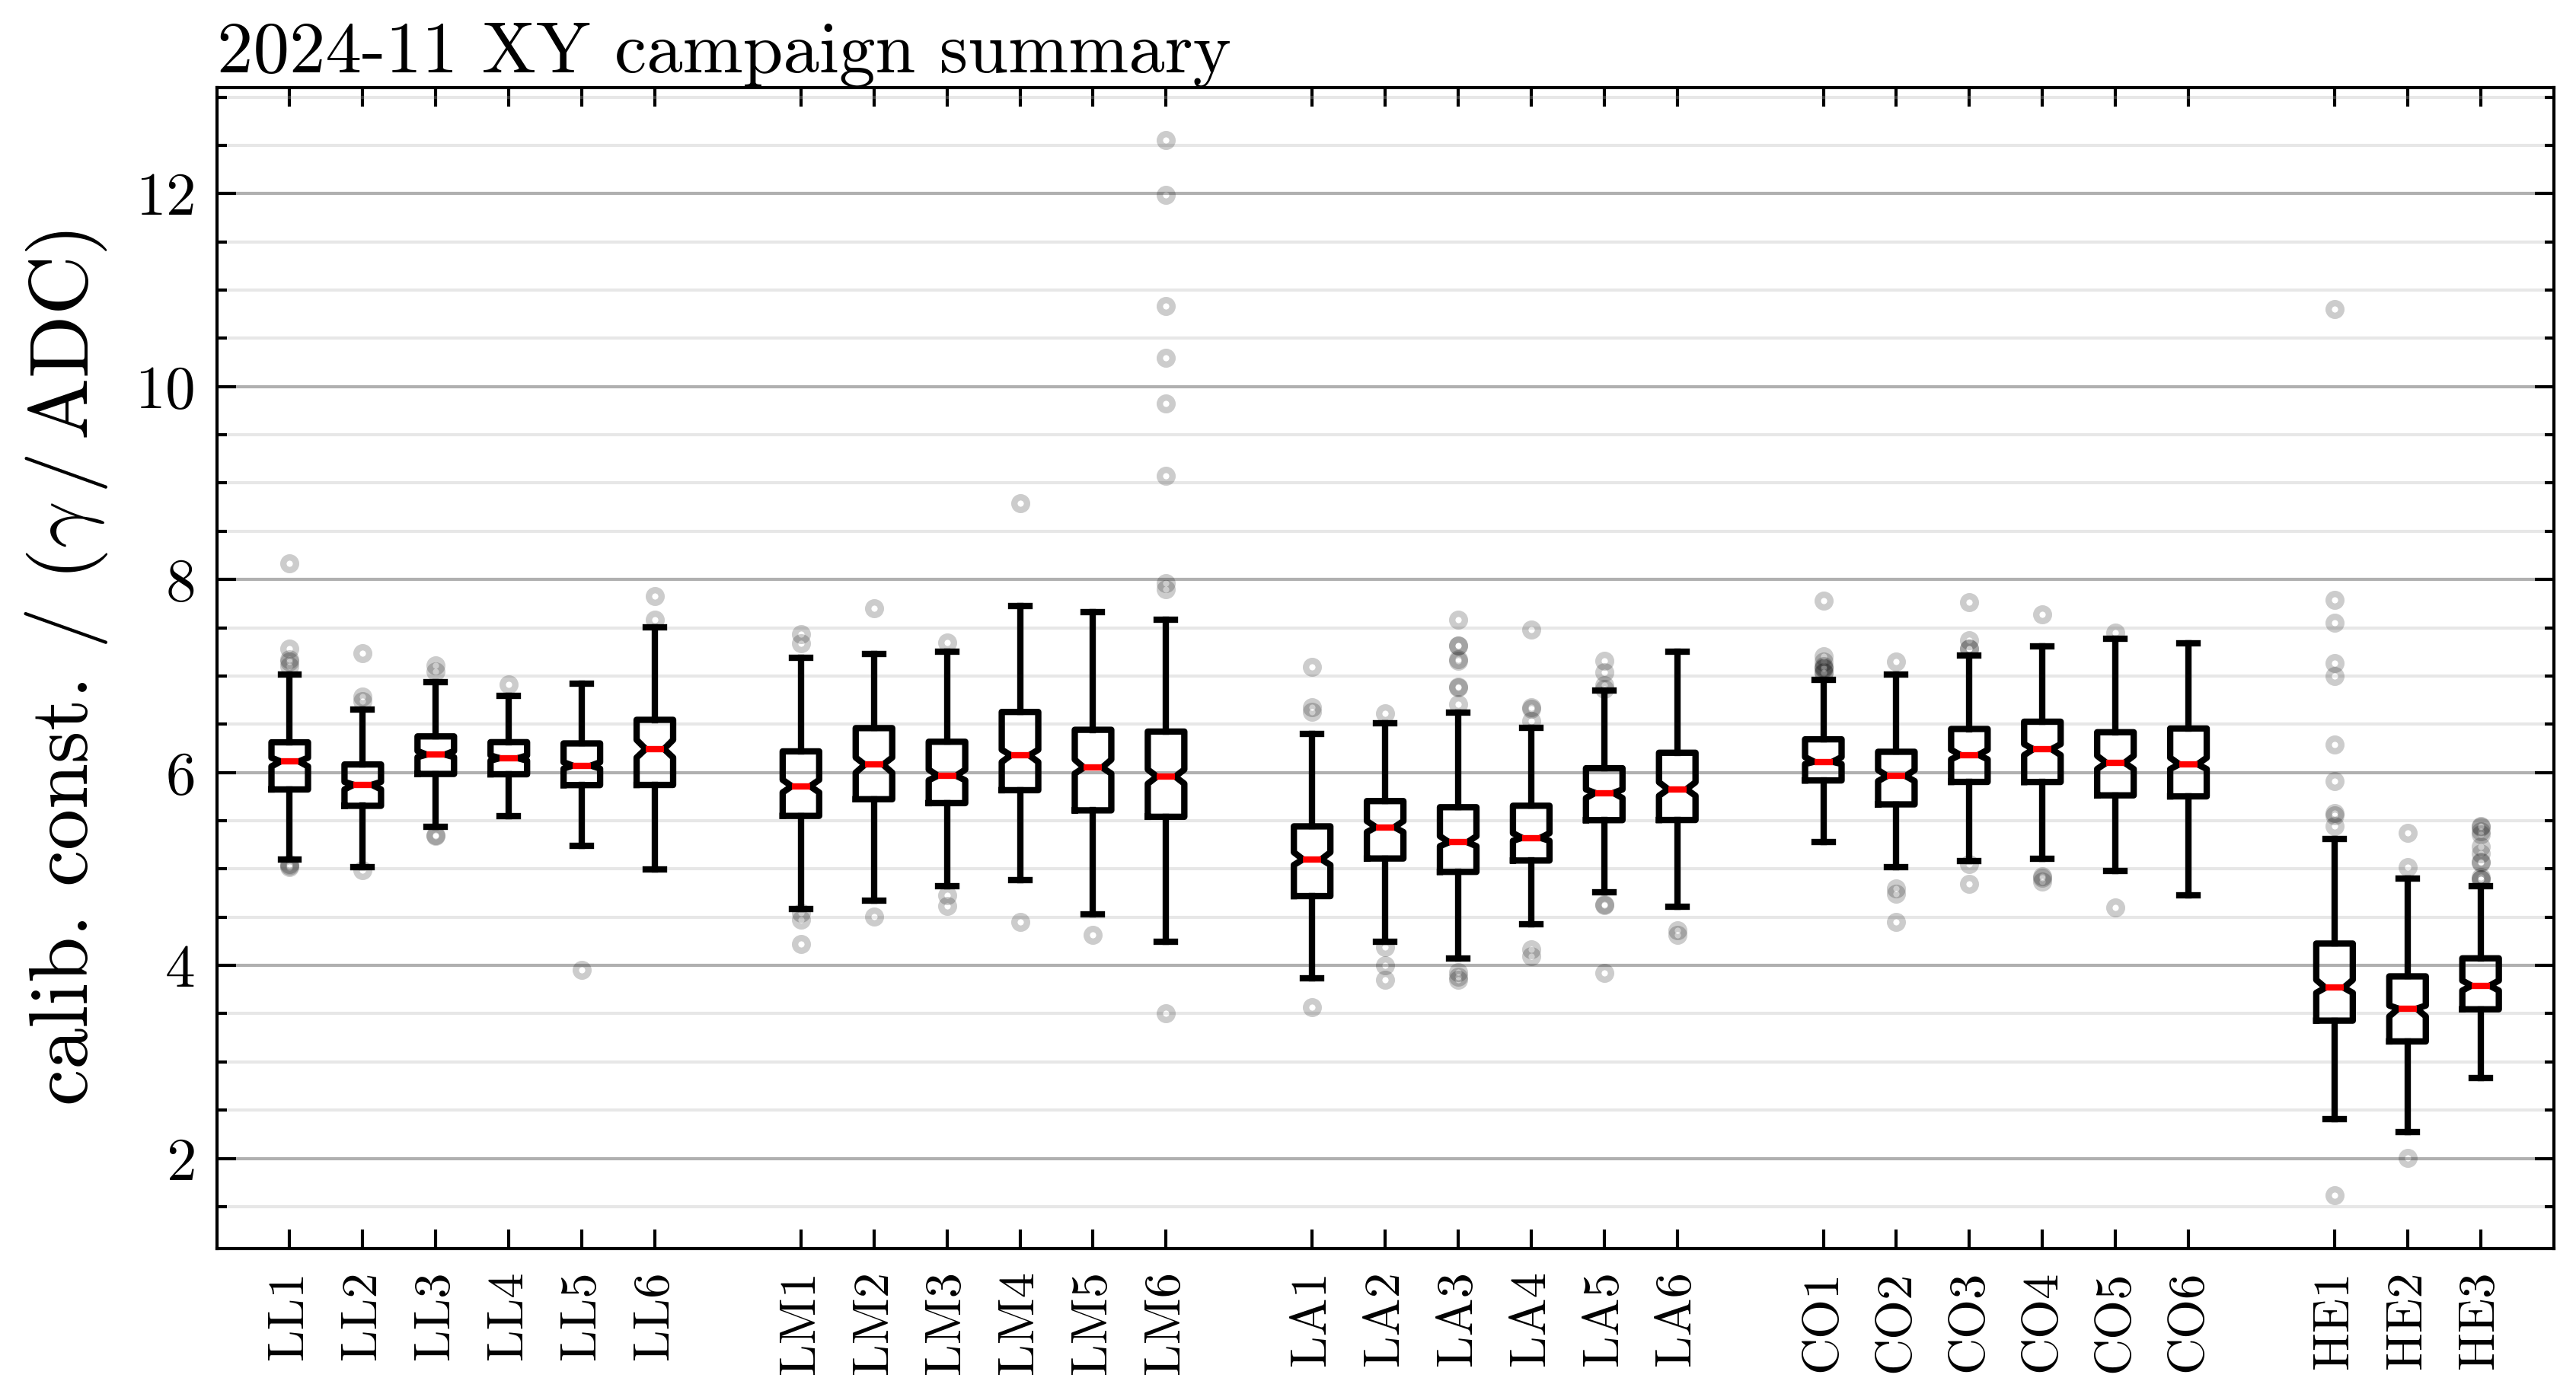

In [5]:
from utils.Auger.FD import XYScanner

test = XYScanner.Campaign(2024, 11)
test.summary()

In [93]:
for run in test:
    print(run)

{'preDAQ': '12298m13', 'preXY': '12327', 'XY': '12328x', 'postXY': '12334'}
{'preDAQ': '12273m14', 'preXY': '12289', 'XY': '12292x', 'postXY': '12296'}
{'preDAQ': '12273m15', 'preXY': '12274', 'XY': '12275x', 'postXY': '12277', 'postDAQ': '12279x'}
{'preDAQ': '12298m16', 'preXY': '12299', 'XY': '12301x', 'postXY': '12305'}
{'preDAQ': '12298m17', 'preXY': '12306', 'XY': '12307x', 'postXY': '12318'}
{'preDAQ': '12298m18', 'preXY': '12319', 'XY': '12320x', 'postXY': '12323'}
{'preDAQ': '6018m25', 'preXY': '6019', 'XY': '6020x', 'postXY': '6023'}
{'preDAQ': '6018m26', 'preXY': '6024', 'XY': '6025', 'postXY': '6026'}
{'preDAQ': '6029m27', 'preXY': '6030', 'XY': '6031x', 'postXY': '6035'}


In [85]:
print(test)

tel    preDAQ    preXY    XY      postXY    postDAQ
-----  --------  -------  ------  --------  ---------
LA1    12298m13  12327    12328x  12334
LA2    12273m14  12289    12292x  12296
LA3    12273m15  12274    12275x  12277     12279x
LA4    12298m16  12299    12301x  12305
LA5    12298m17  12306    12307x  12318
LA6    12298m18  12319    12320x  12323
-----  --------  -------  ------  --------  ---------
HE1    6018m25   6019     6020x   6023
HE2    6018m26   6024     6025    6026
HE3    6029m27   6030     6031x   6035


In [ ]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

fIn = "/cr/data01/filip/xy-calibration/campaign_summary/calib_runs_2024-11_OLO_results.csv"

df = pd.read_csv(fIn, comment='#', index_col=0,
                     dtype=defaultdict(lambda: str, global_pixel=int, mirror=int, 
                                       local_pixel=int, col=int, row=int))
df.columns = df.columns.str.strip()  # remove space in keys
label = fIn
label = label.replace("calib_runs_", "").replace("_results", "")

# because there may be nans in the cal_xy col
# pandas parses it as a default string, need to convert
df["cal_xy"] = df['cal_xy'].str.strip()
df["cal_xy"] = df["cal_xy"].astype(float)
df["mirror"] = df["mirror"].astype(float)

dfTelMean = df.groupby(["telescope"]).mean(numeric_only=True).reset_index()
plt.plot(dfTelMean["mirror"], dfTelMean["cal_xy"], '.', label=label)

In [ ]:
df.dtypes

In [ ]:
dfTelMean

In [ ]:
import pandas as pd
from collections import defaultdict

def load_runlist(year_month: str) -> pd.DataFrame:
    data = pd.read_csv(
        f"/cr/data01/filip/xy-calibration/config/calib_runlists/calib_runs_{year_month}.list",
        names=["id","tel","step","date","source","mA","forDB","jobfile","comment"],
        dtype=defaultdict(lambda: str, step="int", mA="float", forDB="bool"),
        index_col=0,
        comment="#",
        sep=";",
    )

    for col in ["source", "jobfile", "comment"]:
        data[col] = data[col].map(lambda x: x.strip().replace('"',''))

    return data

def get_xy_runs(runlist: pd.DataFrame) -> pd.DataFrame:
    return runlist[
        runlist['forDB']
        ]

def get_good_xy_runs(runlist: pd.DataFrame) -> pd.DataFrame:
    return runlist[
        runlist['forDB']
        & (runlist['step'] == 6)
        & (runlist['source'] == "OLO")
        & (runlist['mA'] == 15.9)
        & (runlist['comment'] == "")
        ]

def get_cal_a_runs(runlist: pd.DataFrame) -> pd.DataFrame:
    return runlist[
        (runlist['step'] == 0)
        & (runlist['source'] == "")
        & (runlist['mA'] == 0)
        ]

def get_cal_a_open_shutter_runs(runlist: pd.DataFrame) -> pd.DataFrame:
    return runlist[
        (runlist['step'] == 0)
        & (runlist['source'] == "")
        & (runlist['mA'] == 0)
        & (runlist['comment'].str.contains("open shutter"))
        ]

runlist=load_runlist('2024-11')

get_xy_runs(runlist)

In [ ]:
print(runlist['source'] == "OLO")

In [ ]:
runlist.iloc[0]['source']

In [ ]:
from utils.Auger.SD.Simulation import Simulation

In [ ]:
sim = Simulation(name='test_sim', offline='ds_forced_station_triggers', 
                 src='/cr/users/filip/Projects/SSDTriggerEfficiency/SdSimulationReconstructionUpgrade/',
                 PRIMARY='photon')

In [ ]:
# sim.run(191)

In [ ]:
sim.status()

In [ ]:
sim.process()

In [ ]:
sim.status()